# Budget Plots for CET activity in BS cell
## Cyclic/Linear eletron transport activity in the bundle sheath cell under low light condition and implemented volume constraint

### Imports

In [1]:
import pandas as pd
from cobra.io import read_sbml_model
from cobra import flux_analysis
import sys
sys.path.append("../Code")
from model_functions import *

### Reading and constraining C4 model

In [2]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("../Models/c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[M]_Maize_biomass_tx'

#Setting up Rubisco carboxylase/oxygenase (3:1) ratio in C4 model
const = c4_model.problem.Constraint(
    3 * c4_model.reactions.get_by_id("[M]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id(
        "[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression, lb=0, ub=0)
c4_model.add_cons_vars(const)

const = c4_model.problem.Constraint(
    3 * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id(
        "[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex").flux_expression, lb=0, ub=0)
c4_model.add_cons_vars(const)

#Block Mesophyll and Bundle Sheath "External" Rubisco
set_bounds("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p", (0, 0), c4_model)
set_bounds("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex", (0,0), c4_model)


def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression, lb=0,
                                          ub=0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression, lb=0,
                                          ub=0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression - 3 * (
            c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id(
        "[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression), lb=0,
                                        ub=0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression - 3 * (
            c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id(
        "[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression), lb=0,
                                        ub=0)
    c4_model.add_cons_vars(const)


#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


## Adding constrains specifics for the experiment

In [3]:
"""
Constrains as described in the Bellasio et al, 2022 paper
"""

#Constrains for BS small volume and low light paper experiment
#Block pyruvate, phosphate dikinase in the BS cell
set_bounds('[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p', (0, 0), c4_model)
set_bounds('[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c', (0, 0), c4_model)

#Block PEP-CK in the BS cell
set_fixed_flux("[B]_PEPCARBOXYKIN_RXN_c", 0, c4_model)

#Enable PSII
set_bounds('[B]_PSII_RXN_p', (0, 1000), c4_model)

### Parameterization of flux simulation

In [4]:

def simul_c4(c4_model, carbon, nitrogen, light, volume_ratio, light_ratio):
    with c4_model:
        c4_model.objective = "[M]_Maize_biomass_tx"
        c4_model.solver = "glpk"
        medium = c4_model.medium
        medium["[M]_CO2_tx"] = carbon  #CO2 Uptake constrain
        medium["[B]_Nitrate_tx"] = nitrogen #Nitrate uptake constrain
        c4_model.medium = medium

        #Constrains for light uptake
        set_bounds("[M]_Photon_tx", ((light/(light_ratio+1)), light/(light_ratio+1)), c4_model)
        set_bounds("[B]_Photon_tx", ((light-(light/(light_ratio+1)))/volume_ratio, (light-(light/(light_ratio+1)))/volume_ratio), c4_model)

        #Implementation of volume constraint in the exchange reactions
        for reaction in c4_model.reactions:
            if reaction.id[0:4] == "[MB]":
                dict = {reaction.products[0] : -(1/volume_ratio)}
                reaction.subtract_metabolites(dict, combine=False)

        solution = flux_analysis.pfba(c4_model)
        solution_frame=solution.to_frame()
        return solution_frame


### Selecting metabolites to budget

In [5]:
"""
Define search parameters

Select metabolites to search
"""

#Defining the list of metabolites to search
budget_metabolites = []

#Defining the compartments within the model
compartment = ["_c", "_m", "_p", "_x", "_e", "_i", "_v", "_l", "tx", "ss"]

#Searching for the metabolites in the model
for met in c4_model.metabolites.query("]_PLASTOQUINONE_"):
    if met.id[:3] == "[B]":
        budget_metabolites.append(met)

budget_metabolites

[<Metabolite [B]_PLASTOQUINONE_p at 0x18285297630>]

### Defining list of consuming and producing reactions from metabolites

In [6]:
"""
Define consuming and producing reactions
"""

#Defining list of reactions producing and consuming the metabolite
consumers = []
producers = []

#Add reactions to respective list and exclude transport reactions
for met in budget_metabolites:
    for reaction in c4_model.reactions:
        if met in reaction.reactants and reaction.id[-2:] in compartment:
            consumers.append(reaction.id)
        elif met in reaction.products and reaction.id[-2:] in compartment:
            producers.append(reaction.id)

### Budget Plot under low light conditions

#### Flux simulation

In [7]:
solution_frame_LL = simul_c4(c4_model, 25, 1000, 350, 1.37, 0.343)
get_C4_fluxes(solution_frame_LL)

Bundle Sheath Rubisco carboxylase 18.07946165628478
External Bundle Sheath Rubisco carboxylase 0.0
Mesophyll Rubisco carboxylase 0.0
Mesophyll PEPC 24.947006338875344
Bundle Sheath PEP-CK 0.0
Bundle Sheath NADP-ME (c) 0.0
Bundle Sheath NADP-ME (p) 17.00242351616826
Bundle Sheath NAD-ME 0.0
Bundle Sheath Glycine Dehydrogenase 0.33587288480464916


### Budget Plot under low light conditions

#### Flux simulation

In [8]:
solution_frame_HL = simul_c4(c4_model, 25, 1000, 1000, 1.38, 0.414)
get_C4_fluxes(solution_frame_HL)

Bundle Sheath Rubisco carboxylase 18.287375974141348
External Bundle Sheath Rubisco carboxylase 0.0
Mesophyll Rubisco carboxylase 0.0
Mesophyll PEPC 24.947006338874626
Bundle Sheath PEP-CK 0.0
Bundle Sheath NADP-ME (c) 0.0
Bundle Sheath NADP-ME (p) 17.015598556967575
Bundle Sheath NAD-ME 0.08956893140407729
Bundle Sheath Glycine Dehydrogenase 0.22046405346537676


### Data preparation for budget plot

In [9]:
"""
Correct consumption/production with regards to directionality
"""
def budget_plot(solution_frame, producers, consumers):
    
    #Get flux values from the simulation for metabolite consuming/producing reactions
    producers_df = solution_frame.loc[producers,:]
    consumers_df = solution_frame.loc[consumers,:]

    #Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
    negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
    negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)


    #Add reactions to correct list
    consumers.extend(negative_producers)
    producers.extend(negative_consumers)

    #Remove reactions with negative flux from old list
    def remove_items(test_list, item):
        res = [i for i in test_list if i != item]
        return res

    for item in negative_producers:
        producers = remove_items(producers, item)

    for item in negative_consumers:
        consumers = remove_items(consumers, item)

    """
    Get producing reactions and fluxes
    """

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    producers_df = solution_frame.loc[producers,:]
    #Make all values positive (disregard directionality)
    print(producers_df)
    producers_df["fluxes"] = producers_df["fluxes"].abs()
    #Remove reactions with zero flux
    producers_df = producers_df[(producers_df.T != 0).all()]
    producers_df


    """
    Get consuming reactions and fluxes
    """

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    consumers_df = solution_frame.loc[consumers,:]
    print(consumers_df)
    #Make all values positive (disregard directionality)
    consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
    #Remove reactions with zero flux
    consumers_df = consumers_df[(consumers_df.T != 0).all()]
    consumers_df

    """
    Concatenate producer and consumer dataframes
    """

    producers_df["Status"] = "Producer"
    consumers_df["Status"] = "Consumer"

    frame = [producers_df, consumers_df]

    all_reactions = pd.concat(frame)

    all_reactions["label"] = all_reactions.index

    #Export full dataframe to csv
    #all_reactions.to_csv("budget_plot.csv", header=True)

    #Correct Budget stoichiometry
    atp_stoi=[]
    for i in all_reactions['label']:
        for met in budget_metabolites:
            try:
                rxn=c4_model.reactions.get_by_id(i).get_coefficient(met)
                atp_stoi.append(abs(rxn))
            except KeyError:
                continue

    new_flux = all_reactions["fluxes"] * atp_stoi

    all_reactions.insert(3,'coefficient', atp_stoi)
    all_reactions.insert(4,'new_flux', new_flux)

    """
    Fluxes in consumption and production should be equal
    """

    #Sum the flux values
    print("Sum of fluxes: {}".format(all_reactions.groupby(["Status"]).new_flux.sum()))

    """
    Pick the colors - using random
    """

    import random
    import matplotlib.pyplot as plt


    #Defining the nº of colors
    number_of_colors = len(all_reactions.index)

    #Getting a list of colors
    random.seed(177)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                for i in range(number_of_colors)]

    #Getting list of reactions
    reaction_list = list(all_reactions.index)

    #Build color dictionary
    color_dict = {}
    for i in range(len(reaction_list)):
        color_dict[reaction_list[i]] = color[i]

    """
    Plot the pivot table and barplot
    """

    plt.style.use('fast')

    chart = all_reactions.pivot_table(index="Status", columns="label", values="new_flux")
    chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
    plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
    plt.title("Platoquinone Turnover in the Bundle Sheath Cell")
    figsize = [11, 11] #To prevent the cropping of the image
    chart


### Budget Plot Vizualisation

#### Low light conditions

                                                  fluxes  reduced_costs
[B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p  25.710888      -2.000000
[B]_Plastoquinol_Oxidase_p                      0.000000      -3.970419
                                             fluxes  reduced_costs
[B]_lycopene_biosynthesis_p                0.000000      -2.000000
[B]_Ferredoxin_Plastoquinone_Reductase_p   0.000000       1.343194
[B]_PSII_RXN_p                             3.456495      -2.000000
[B]_NADPH_Dehydrogenase_p                 18.797897      -2.000000
Sum of fluxes: Status
Consumer    25.710888
Producer    25.710888
Name: new_flux, dtype: float64


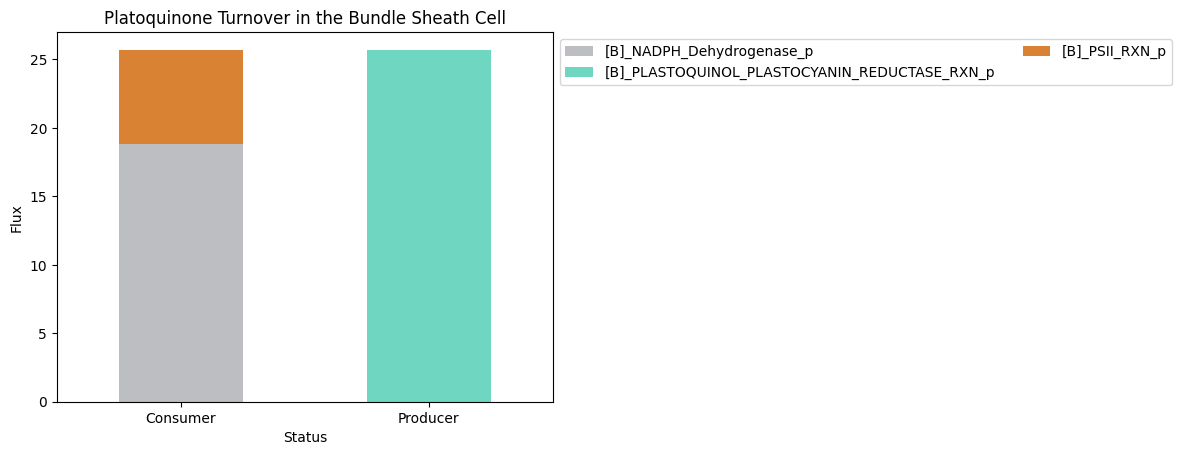

In [10]:
budget_plot(solution_frame_LL, producers, consumers)

#### High light conditions

                                                  fluxes  reduced_costs
[B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p  53.041018           -2.0
[B]_Plastoquinol_Oxidase_p                      0.000000          -11.5
                                             fluxes  reduced_costs
[B]_lycopene_biosynthesis_p                0.000000          -2.00
[B]_Ferredoxin_Plastoquinone_Reductase_p   0.000000           1.25
[B]_PSII_RXN_p                            26.520509          -2.00
[B]_NADPH_Dehydrogenase_p                  0.000000           5.25
Sum of fluxes: Status
Consumer    53.041018
Producer    53.041018
Name: new_flux, dtype: float64


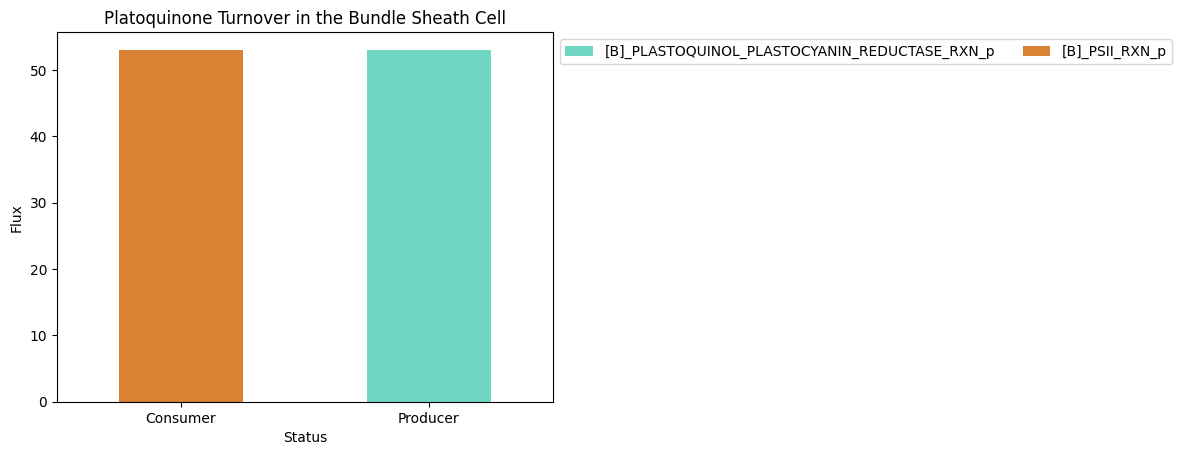

In [11]:
budget_plot(solution_frame_HL, producers, consumers)